# Case de Clustering e Recomendação

O CEO da Amazon contratou um time de cientistas de dados
para trabalhar em diferentes vertentes da empresa, e você
ficou encarregado de fazer um sistema de recomendação para
os clientes Amazon. Para isso, te deram acesso à uma base de
dados não muito estruturada em Json: um arquivo de
metadata com informações dos produtos e outro com as
avaliações.

O CEO deseja que seu algoritmo de recomendação seja
exclusivamente em cima de avaliações verificadas (campo
`verified`=True no arquivo de avaliações). Contudo, há uma
base sem classificação e que o CEO faz questão de que seja
adicionada no sistema de recomendação (valores com missing
value na coluna `verified`). Para isso, você precisará classificar
se estas avaliações são verificadas ou não, e no caso positivo,
adicioná-los no sistema de recomendação.
Adicionalmente, o CEO também deseja saber de possíveis
associações e/ou correlações nesta base de dados que você vai
trabalhar.

Desta forma, eis o que você deve fazer neste projeto:
- Carregar, limpar e fazer análises exploratórias no banco de
dados fornecido;
- Classificar a base sem informação para incluir as observações
das avaliações verificadas no sistema de recomendação;
- Desenvolver e entregar um sistema de recomendação, com
exemplos de aplicação.
OBS: O desenvolvimento e a decisão do modelo é totalmente
sua, portanto se achar que deve utilizar um valor/
procedimento diferente, sinta-se livre para fazer os testes e
validar suas hipóteses para achar o resultado coerente.

# Importando as bibliotecas e carregando os dados

In [121]:
## Importando as bibliotecas necessárias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df_vg = pd.read_json(r'Video_Games_sample.json', lines=True)
df_metavg = pd.read_json(r'meta_Video_Games.json', lines=True)

In [3]:
print(f' Dimensão do df_vg: {df_vg.shape}')
print(f' Dimensão do df_vg: {df_metavg.shape}')

 Dimensão do df_vg: (453562, 12)
 Dimensão do df_vg: (84819, 19)


# EDA

## Dataset df_vg

In [4]:
df_vg.head(2)

,overall,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,verified,vote,image
0,1,"01 2, 2018",A16FEXIKAPT24U,B00000JRSB,{'Format:': ' Video Game'},Nicholas Sabin,Game disc was cracked thats pretty lame,Game disc 1 was cracked,1514851200,NaN,NaN,NaN
1,5,"01 2, 2018",A3ISBEPYLY8IMO,B00000JRSB,{'Format:': ' Video Game'},Jimmy,Received this in perfect condition. Great rese...,Received this in perfect condition. Great rese...,1514851200,1.0,NaN,NaN


In [5]:
df_vg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453562 entries, 0 to 453561
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         453562 non-null  int64  
 1   reviewTime      453562 non-null  object 
 2   reviewerID      453562 non-null  object 
 3   asin            453562 non-null  object 
 4   style           318160 non-null  object 
 5   reviewerName    453511 non-null  object 
 6   reviewText      453217 non-null  object 
 7   summary         453396 non-null  object 
 8   unixReviewTime  453562 non-null  int64  
 9   verified        384546 non-null  float64
 10  vote            57123 non-null   object 
 11  image           4651 non-null    object 
dtypes: float64(1), int64(2), object(9)
memory usage: 41.5+ MB


In [6]:
## Verificando se há valores nulos no dataset

(df_vg.isna().sum()/df_vg.shape[0]).map("{:.2%}".format)

overall            0.00%
reviewTime         0.00%
reviewerID         0.00%
asin               0.00%
style             29.85%
reviewerName       0.01%
reviewText         0.08%
summary            0.04%
unixReviewTime     0.00%
verified          15.22%
vote              87.41%
image             98.97%
dtype: object

As colunas vote e image possuem muitos nulos, vamos remove-las do dataset

In [7]:
## Vamos dropar as colunas abaixo:

df_vg.drop(columns=['image', 'vote'], inplace=True)

Verificando a distribuição das notas

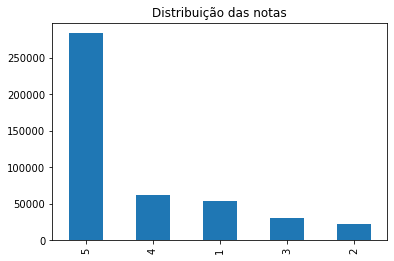

In [8]:
plt.title('Distribuição das notas')
df_vg['overall'].value_counts().plot(kind='bar')
plt.show()

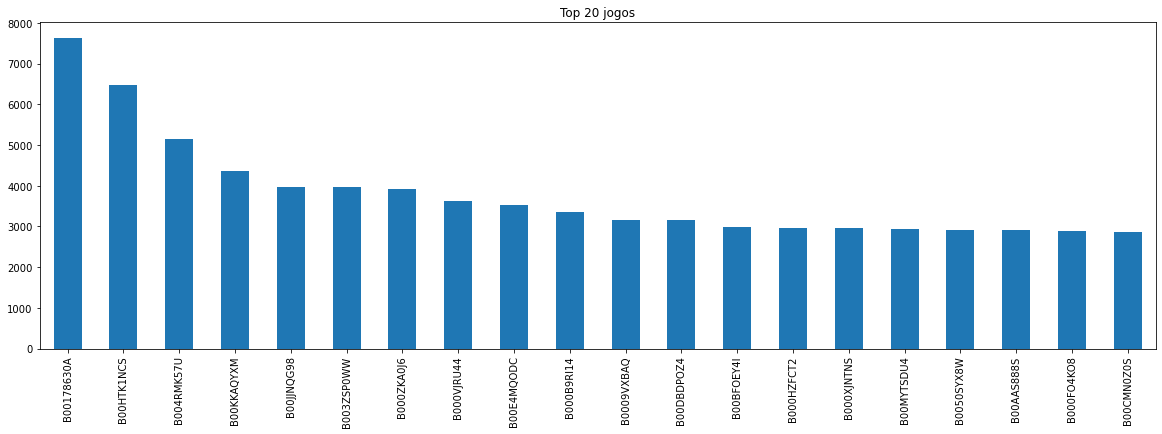

In [9]:
plt.figure(figsize=(20, 6))
plt.title('Top 20 jogos')
df_vg['asin'].value_counts()[:20].plot(kind='bar')
plt.show()

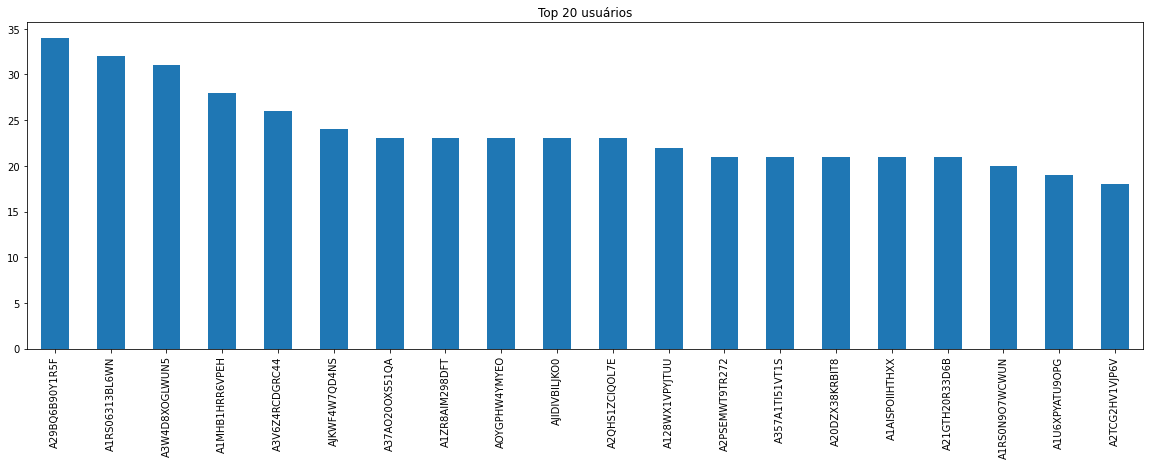

In [10]:
plt.figure(figsize=(20, 6))
plt.title('Top 20 usuários')
df_vg['reviewerID'].value_counts()[:20].plot(kind='bar')
plt.show()

### Formantando a coluna Style

In [11]:
style = pd.json_normalize(df_vg['style'])

In [12]:
(style.isna().sum()/style.shape[0]).map("{:.2%}".format)

Format:                 68.25%
Color:                  85.16%
Length:                 97.95%
Subscription Length:    97.96%
Content:                99.91%
Size:                   96.10%
Style:                  90.14%
Package Quantity:       99.75%
Edition:                88.98%
Platform:               89.75%
Package Type:           98.62%
Configuration:          99.75%
Pattern:                99.71%
dtype: object

Como a maioria dos itens no dicionário da coluna style são nulos e não trazem informações relevantes, vamos remove-la

In [13]:
df_vg.drop(columns='style',inplace=True)

Verificando a quantidade 'verified' nulos para poder classifica-los conforme solicita o exercício.

In [14]:
df_vg['verified'].isnull().sum()

69016

In [15]:
df_vg.nunique()

overall                5
reviewTime          6066
reviewerID        361288
asin                 266
reviewerName      245576
reviewText        376697
summary           228253
unixReviewTime      6066
verified               2
dtype: int64

In [16]:
df_vg.shape

(453562, 9)

## Dataset df_metavg

In [17]:
df_metavg.head(2)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"[Video Games, PC, Games]",,[],,Reversi Sensory Challenger,[],,Fidelity Electronics,[],"[>#2,623,937 in Toys &amp; Games (See Top 100 ...",[],Toys &amp; Games,,,,0042000742,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
1,"[Video Games, Xbox 360, Games, </span></span><...",,[Brand new sealed!],,Medal of Honor: Warfighter - Includes Battlefi...,[B00PADROYW],,by\n \n EA Games,[],"[>#67,231 in Video Games (See Top 100 in Video...","[B0050SY5BM, B072NQJCW5, B000TI836G, B002SRSQ7...",Video Games,,,"\n\t\t\t\t\t\t\t\t\t\t\t\t<span class=""vertica...",0078764343,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN


In [18]:
df_metavg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84819 entries, 0 to 84818
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   category         84819 non-null  object
 1   tech1            84819 non-null  object
 2   description      84819 non-null  object
 3   fit              84819 non-null  object
 4   title            84819 non-null  object
 5   also_buy         84819 non-null  object
 6   tech2            84819 non-null  object
 7   brand            84819 non-null  object
 8   feature          84819 non-null  object
 9   rank             84819 non-null  object
 10  also_view        84819 non-null  object
 11  main_cat         84819 non-null  object
 12  similar_item     84819 non-null  object
 13  date             84819 non-null  object
 14  price            84819 non-null  object
 15  asin             84819 non-null  object
 16  imageURL         84819 non-null  object
 17  imageURLHighRes  84819 non-null

Temos algumas colunas bem desorganizadas e que não vão agregar em nosso dataset por isso vamos remover:

category: já temos uma coluna 'main_cat', não precisamos dela.

tech1: está vazia

description: não será necessária

fit: está vazia

tech2: está vazia

feature: não será necessária

rank: não será necessária

similar_item: vazia

date: não será necessária

price: não será necessária

imageURL: não será necessária

imageURLHighRes: não será necessária

details: não será necessária

In [19]:
## Vamos dropar algumas colunas que não vão ser úteis.

df_metavg.drop(columns=['category', 'tech1', 'description', 'fit', 'tech2', 'feature', 'rank', 'similar_item','imageURL',
 'date', 'price','imageURLHighRes', 'details'], inplace=True)

In [20]:
df_metavg.shape

(84819, 6)

In [21]:
df_metavg.asin.duplicated().value_counts()

False    71911
True     12908
Name: asin, dtype: int64

Existem valores duplicados, portanto vamos remover.

In [22]:
df_metavg = df_metavg.drop_duplicates(subset='asin', keep='first')

Para reduzir nosso dataset de produto, vamos deixar somente os produtos que os clientes avaliaram

In [23]:
vg_vlaues = df_vg['asin'].values

In [24]:
df_metavg = df_metavg[df_metavg['asin'].isin(vg_vlaues)]

In [25]:
df_metavg.shape

(266, 6)

In [26]:
df_metavg.main_cat.value_counts()

Video Games          198
Computers             52
All Electronics       14
Sports & Outdoors      1
Amazon Home            1
Name: main_cat, dtype: int64

Arrumando a coluna de brand

In [27]:
df_metavg['brand'] = df_metavg['brand'].str.replace('\n',"")

In [28]:
df_metavg['brand'] = df_metavg['brand'].str.replace('by ',"")

In [29]:
df_metavg

,title,also_buy,brand,also_view,main_cat,asin
399,Final Fantasy VII,"[B0000296O5, B00004Y57G, B00002R28C, B0045L3SN...",SquareSoft,"[B00004Y57G, B00004TC6E, B00ZS80PC2, B0000296O...",Video Games,B00000JRSB
6758,Halo - Xbox,"[B00008J7NZ, B00006IR20, B000FRU0NU, B00005RHQ...",Microsoft,"[B0050SYY5E, B000FRU0NU, B00008J7NZ, B00006IR2...",Video Games,B00005NZ1G
6779,Grand Theft Auto III,"[B0000696CZ, B0001VGFK2, B01L1P49OA, B00006BXB...",Sony,"[B0000696CZ, B0001VGFK2, B00006BXBV, B000KCX9M...",Video Games,B00005O0I2
6975,Super Smash Bros Melee,"[B00009WAUD, B00006IJJI, B00005QEFF, B01LWA474...",Nintendo,"[B000094G2O, B00008KTX5, B00009WAUD, B0009XBYZ...",Video Games,B00005Q8M0
7244,Final Fantasy X,"[B00008URUA, B000F5IH2I, B000066TS5, B0009A4EV...",SquareSoft,"[B000066TS5, B000F5IH2I, B00008URUA, B00QU47SJ...",Video Games,B00005TNI6
...,...,...,...,...,...,...
84373,The Elder Scrolls V: Skyrim Special Edition - ...,"[B004RMK4BC, B004RMK4P8, B06XCTDL52, B00GAC1D2...",Bethesda,"[B01J23D1W4, B01H0TJM70, B07L9NVPTY, B07BZZX97...",Video Games,B01GW3ODBU
84386,God of War 4 - PS4 [Digital Code],"[B01H0TJM70, B07G9WK8GS, B072LXFN8X, B07DLTC77...",SCEA,"[B01H0TJM70, B01GW3PMGK, B072LXFN8X, B07G9WK8G...",Video Games,B01GW3P9PE
84506,"PS4 Controller Charger, Y Team Playstation 4 /...","[B01LWVX2RG, B07GQ61M42, B0799976M1, B07FQ74V4...",Y Team,[],All Electronics,B01H1GJ7IQ
84561,Nintendo Pokemon Go Plus,"[B07C7K7JGW, B07HNC7JB9, B07C75329M, B07C7L9D9...",Nintendo,"[B071K63M65, B06Y5BTX8L, B071R3P45V, B07C1MCH3...",Video Games,B01H482N6E


# Juntando os dois datasets

In [30]:
df_final = df_vg.merge(df_metavg, how='inner', on='asin')

In [31]:
df_final.drop(columns='reviewTime', inplace=True)

In [32]:
df_final.head(2)

,overall,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,verified,title,also_buy,brand,also_view,main_cat
0,1,A16FEXIKAPT24U,B00000JRSB,Nicholas Sabin,Game disc was cracked thats pretty lame,Game disc 1 was cracked,1514851200,NaN,Final Fantasy VII,"[B0000296O5, B00004Y57G, B00002R28C, B0045L3SN...",SquareSoft,"[B00004Y57G, B00004TC6E, B00ZS80PC2, B0000296O...",Video Games
1,5,A3ISBEPYLY8IMO,B00000JRSB,Jimmy,Received this in perfect condition. Great rese...,Received this in perfect condition. Great rese...,1514851200,1.0,Final Fantasy VII,"[B0000296O5, B00004Y57G, B00002R28C, B0045L3SN...",SquareSoft,"[B00004Y57G, B00004TC6E, B00ZS80PC2, B0000296O...",Video Games


# CLASSIFICAÇÃO

Vamos montar de um modelo de classificação para prever a coluna 'verified'

In [33]:
# Cópia do dataset para classificação
df_clf = df_final.copy()

# Cópia do dataset para valores nulos em verified
df_clf_null = df_clf[df_clf['verified'].isnull()]

# Cópia do dataset para valores sem os nulos em verified
df_clf_model = df_clf.dropna(subset=['verified'])

Dropando as colunas que não serão usadas para faer o modelo

In [34]:
df_clf_model.drop(columns=['reviewerName', 'reviewText', 'summary', 'title', 'also_buy', 'brand', 'also_view'], inplace=True)

c:\Users\Public\Anaconda\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Dummificando nossa coluna de categoria

In [35]:
df_clf_model = pd.get_dummies(df_clf_model, columns=['main_cat'])

In [36]:
df_clf_model.head(1)

,overall,reviewerID,asin,unixReviewTime,verified,main_cat_All Electronics,main_cat_Amazon Home,main_cat_Computers,main_cat_Sports & Outdoors,main_cat_Video Games
1,5,A3ISBEPYLY8IMO,B00000JRSB,1514851200,1.0,0,0,0,0,1


In [37]:
df_clf['main_cat'].unique()

array(['Video Games', 'All Electronics', 'Computers', 'Sports & Outdoors',
       'Amazon Home'], dtype=object)

In [38]:
column_names = {
                'main_cat_All Electronics' : 'all_eletronics',
                'main_cat_Amazon Home' : 'amazon_home',
                'main_cat_Computers' : 'computers',
                'main_cat_Sports & Outdoors' : 'sports_outdoors',
                'main_cat_Video Games' : 'video_games' 
                }

In [39]:
df_clf_model.rename(column_names, axis=1, inplace=True)

In [40]:
df_clf_model

,overall,reviewerID,asin,unixReviewTime,verified,all_eletronics,amazon_home,computers,sports_outdoors,video_games
1,5,A3ISBEPYLY8IMO,B00000JRSB,1514851200,1.0,0,0,0,0,1
2,5,A1RIUB1PZWLOVZ,B00000JRSB,1513814400,1.0,0,0,0,0,1
3,5,A2VY0K54SOCG0F,B00000JRSB,1513728000,0.0,0,0,0,0,1
4,5,A1ABJQ2REV14OQ,B00000JRSB,1513641600,1.0,0,0,0,0,1
5,5,A368DF2G0T502X,B00000JRSB,1512777600,1.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
453556,1,A3NR3JO8QXRNTN,B01H6GUCCQ,1538265600,1.0,0,0,1,0,0
453557,5,A3QBMO3NTKUU21,B01H6GUCCQ,1538265600,1.0,0,0,1,0,0
453558,1,A3ELGOLQ8393WC,B01H6GUCCQ,1538265600,1.0,0,0,1,0,0
453559,2,A2MMNV4U0G39S6,B01H6GUCCQ,1538179200,1.0,0,0,1,0,0


In [41]:
df_clf_model['verified'].value_counts()

1.0    314250
0.0     70296
Name: verified, dtype: int64

Como o nosso dataset está desbalanceado, vamos pegar uma amostra com 100.000 verified=True

In [42]:
sample_verified = df_clf_model[df_clf_model['verified']==1].sample(100000)
sample_NonVerified = df_clf_model[df_clf_model['verified']==0]
sample = sample_verified.append(sample_NonVerified)

In [43]:
sample.head()

,overall,reviewerID,asin,unixReviewTime,verified,all_eletronics,amazon_home,computers,sports_outdoors,video_games
305814,4,AVKAES8JTAT4W,B00HTK1NCS,1483747200,1.0,0,0,1,0,0
167720,5,A1OB6LDS4U0UDZ,B005JB84GM,1433635200,1.0,0,0,0,0,1
318892,4,A3PDR47IGN9TA4,B00IVJ1M7M,1404432000,1.0,0,0,0,0,1
136528,1,A2NJ9STIFNA6FZ,B003YC4D9A,1449705600,1.0,0,0,1,0,0
73039,1,ARI9WIQBVHMZS,B0015AARJI,1450224000,1.0,0,0,0,0,1


In [44]:
X = sample.drop(columns=['reviewerID', 'asin', 'verified'])
y = sample[['verified']]

In [45]:
print(X.shape)
print(y.shape)

(170296, 7)
(170296, 1)


Train Test Split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

In [47]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((136236, 7), (34060, 7), (136236, 1), (34060, 1))

Normalizando nosso modelo

In [48]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [49]:
scores_list = []
models_list = []

## Regressão Logística

In [50]:
clf_LR = LogisticRegression()
clf_LR.fit(X_train_scaled, y_train)

c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [51]:
y_pred_LR = clf_LR.predict(X_test_scaled)

acuracia_LR = accuracy_score(y_test, y_pred_LR)
f1_score_LR = f1_score(y_test, y_pred_LR)
recall_LR = recall_score(y_test, y_pred_LR)
precision_LR = precision_score(y_test, y_pred_LR)

models_list.append('Regressão Logística')
scores_list.append({'acuracia': acuracia_LR, 'f1-score': f1_score_LR, 'recall': recall_LR, 'precision': precision_LR})

print(f'Acurácia: {acuracia_LR:.2%}')
print(f'F-1 Score: {f1_score_LR:.2%}')
print(f'Recall: {recall_LR:.2%}')
print(f'Precision: {precision_LR:.2%}')

Acurácia: 73.01%
F-1 Score: 78.88%
Recall: 86.31%
Precision: 72.62%


## Gradient Boosting

In [52]:
clf_Gb = GradientBoostingClassifier(n_estimators=250, subsample=1)
clf_Gb.fit(X_train_scaled, y_train)

y_pred_Gb = clf_Gb.predict(X_test_scaled)

acuracia_Gb = accuracy_score(y_test, y_pred_Gb)
f1_score_Gb = f1_score(y_test, y_pred_Gb)
recall_Gb = recall_score(y_test, y_pred_Gb)
precision_Gb = precision_score(y_test, y_pred_Gb)

models_list.append('GradientBoosting')
scores_list.append({'acuracia': acuracia_Gb, 'f1-score': f1_score_Gb, 'recall': recall_Gb, 'precision': precision_Gb})

print(f'Acurácia: {acuracia_Gb:.2%}')
print(f'F-1 Score: {f1_score_Gb:.2%}')
print(f'Recall: {recall_Gb:.2%}')
print(f'Precision: {precision_Gb:.2%}')

c:\Users\Public\Anaconda\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Acurácia: 74.42%
F-1 Score: 80.15%
Recall: 88.49%
Precision: 73.25%


## Random Forest


In [53]:
clf_RFC = RandomForestClassifier()
clf_RFC.fit(X_train_scaled, y_train)

y_pred_RFC = clf_RFC.predict(X_test_scaled)

acuracia_RF = accuracy_score(y_test, y_pred_RFC)
f1_score_RF = f1_score(y_test, y_pred_RFC)
recall_RF = recall_score(y_test, y_pred_RFC)
precision_RF = precision_score(y_test, y_pred_RFC)

models_list.append('RandomForest')
scores_list.append({'acuracia': acuracia_RF, 'f1-score': f1_score_RF, 'recall': recall_RF, 'precision': precision_RF})

print(f'Acurácia: {acuracia_RF:.2%}')
print(f'F-1 Score: {f1_score_RF:.2%}')
print(f'Recall: {recall_RF:.2%}')
print(f'Precision: {precision_RF:.2%}')

C:\Users\IANROS~1\AppData\Local\Temp/ipykernel_4000/948922541.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_RFC.fit(X_train_scaled, y_train)


Acurácia: 72.14%
F-1 Score: 77.63%
Recall: 82.77%
Precision: 73.09%


In [54]:
y_pred_RFC

array([1., 0., 1., ..., 0., 0., 0.])

## Avaliação dos Modelos

In [55]:
df_scores = pd.DataFrame(scores_list, index=models_list)
df_scores

,acuracia,f1-score,recall,precision
Regressão Logística,0.730123,0.788787,0.863120,0.726242
GradientBoosting,0.744157,0.801549,0.884944,0.732517
RandomForest,0.721433,0.776258,0.827668,0.730861


### Aplicando o Modelo na nossa base de valores nulos

In [56]:
df_clf_null.drop(columns=['reviewerName', 'reviewText', 'summary', 'title', 'also_buy', 'brand', 'also_view'], inplace=True)
df_clf_null = pd.get_dummies(df_clf_null, columns=['main_cat'])
df_clf_null.rename(column_names, axis=1, inplace=True)


c:\Users\Public\Anaconda\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [57]:
df_clf_null.drop(columns='verified', inplace=True)

In [58]:
df_clf_null = df_clf_null.astype({
    'reviewerID':'string',
    'asin':'string'
})

In [59]:
df_clf_null.dtypes

overall             int64
reviewerID         string
asin               string
unixReviewTime      int64
all_eletronics      uint8
amazon_home         uint8
computers           uint8
sports_outdoors     uint8
video_games         uint8
dtype: object

In [60]:
df_clf_null_scaled = scaler.transform(df_clf_null.select_dtypes(include=np.number))

In [61]:
y_pred_real = clf_Gb.predict(df_clf_null_scaled)

In [62]:
df_clf_null['verified'] = clf_Gb.predict(df_clf_null_scaled)

In [63]:
df_clf_null['verified'].value_counts()

1.0    55722
0.0    13294
Name: verified, dtype: int64

In [64]:
df_clf_null

,overall,reviewerID,asin,unixReviewTime,all_eletronics,amazon_home,computers,sports_outdoors,video_games,verified
0,1,A16FEXIKAPT24U,B00000JRSB,1514851200,0,0,0,0,1,1.0
12,5,A3562CUJCAN1JW,B00000JRSB,1503878400,0,0,0,0,1,1.0
13,5,AF1XK2YMF5Z1M,B00000JRSB,1502150400,0,0,0,0,1,1.0
19,5,AHKCTYD9XZOMZ,B00000JRSB,1495497600,0,0,0,0,1,1.0
23,5,A3IRUK7Z3G8GBL,B00000JRSB,1492473600,0,0,0,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...
453535,5,A3USITYG2G0KXO,B01H6GUCCQ,1523059200,0,0,1,0,0,1.0
453540,5,A61UB8TF6JPUZ,B01H6GUCCQ,1523059200,0,0,1,0,0,1.0
453545,4,A2GTTLZ13XY720,B01H6GUCCQ,1522972800,0,0,1,0,0,1.0
453552,1,A1M05ZAV4GVYFO,B01H6GUCCQ,1538438400,0,0,1,0,0,1.0


In [65]:
df_final['verified'] = df_final['verified'].fillna(df_clf_null['verified'])

In [66]:
df_final['verified'].value_counts()

1.0    369972
0.0     83590
Name: verified, dtype: int64

In [67]:
df_final[df_final['verified']==1].head()

,overall,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,verified,title,also_buy,brand,also_view,main_cat
0,1,A16FEXIKAPT24U,B00000JRSB,Nicholas Sabin,Game disc was cracked thats pretty lame,Game disc 1 was cracked,1514851200,1.0,Final Fantasy VII,"[B0000296O5, B00004Y57G, B00002R28C, B0045L3SN...",SquareSoft,"[B00004Y57G, B00004TC6E, B00ZS80PC2, B0000296O...",Video Games
1,5,A3ISBEPYLY8IMO,B00000JRSB,Jimmy,Received this in perfect condition. Great rese...,Received this in perfect condition. Great rese...,1514851200,1.0,Final Fantasy VII,"[B0000296O5, B00004Y57G, B00002R28C, B0045L3SN...",SquareSoft,"[B00004Y57G, B00004TC6E, B00ZS80PC2, B0000296O...",Video Games
2,5,A1RIUB1PZWLOVZ,B00000JRSB,Amazon Customer,I had a hard time finding this game locally or...,I am very pleased with this purchase,1513814400,1.0,Final Fantasy VII,"[B0000296O5, B00004Y57G, B00002R28C, B0045L3SN...",SquareSoft,"[B00004Y57G, B00004TC6E, B00ZS80PC2, B0000296O...",Video Games
4,5,A1ABJQ2REV14OQ,B00000JRSB,Thiago,"I bought as a gift for my friend, she is so ex...",Loved by lots of people,1513641600,1.0,Final Fantasy VII,"[B0000296O5, B00004Y57G, B00002R28C, B0045L3SN...",SquareSoft,"[B00004Y57G, B00004TC6E, B00ZS80PC2, B0000296O...",Video Games
5,5,A368DF2G0T502X,B00000JRSB,Jonathan carter,"Looks good, some scratches on discs but plays.",Five Stars,1512777600,1.0,Final Fantasy VII,"[B0000296O5, B00004Y57G, B00002R28C, B0045L3SN...",SquareSoft,"[B00004Y57G, B00004TC6E, B00ZS80PC2, B0000296O...",Video Games


## Montando o modelo de recomendação

In [68]:
df_recomendacao = df_final[df_final['verified']==1]

In [69]:
num_overall = df_recomendacao.groupby(by=['asin', 'title']).agg({
    'overall':'count'
}) \
    .reset_index()

num_overall.rename(columns={'overall':'num_overall'}, inplace=True)
num_overall.sort_values('num_overall', ascending=False).head(10)

,asin,title,num_overall
176,B00HTK1NCS,"Redragon M601 Wired Gaming Mouse, Ergonomic, P...",5944
80,B004RMK57U,Playstation Plus: 3 Month Membership [Digital ...,4991
191,B00KKAQYXM,"HAVIT HV-MS672 3200DPI Wired Mouse, 4 Adjustab...",4032
74,B003ZSP0WW,Xbox 360 Wireless Controller - Glossy Black,3748
184,B00JJNQG98,"HyperX Cloud Gaming Headset for PC, Xbox One&s...",3718
156,B00E4MQODC,Logitech G602 Lag-Free Wireless Gaming Mouse &...,3248
12,B000B9RI14,Xbox 360 LIVE 1600 Points,3057
149,B00DBDPOZ4,Xbox One Play and Charge Kit,2892
20,B000HZFCT2,Microsoft Xbox 360 Wireless Receiver for Windows,2793
133,B00CMN0Z0S,60GB Hard Disk Drive for Xbox 360 Slim,2791


In [70]:
avg_overall = df_recomendacao.groupby(by=['asin', 'title']).agg({
    'overall':'mean'
}) \
    .reset_index()

avg_overall.rename(columns={'overall':'avg_overall'}, inplace=True)
avg_overall.sort_values('avg_overall', ascending=False).head(10)

,asin,title,avg_overall
113,B00AKIPBNS,Fire Emblem: Awakening,4.798387
48,B0017KIBAI,Official Nintendo White Classic Gamecube Contr...,4.793351
224,B00UG63VDG,TAKECASE New 3DS XL and 2DS XL Carrying Case -...,4.793137
150,B00DC7G0GG,Super Mario 3D World - Nintendo Wii U,4.789817
190,B00KI2OZ9M,Pok&eacute;mon Omega Ruby - Nintendo 3DS,4.772516
188,B00K848IH0,Pokemon Alpha Sapphire - Nintendo 3DS,4.768563
153,B00DD0B1R0,Super Smash Bros. - Nintendo 3DS,4.765945
171,B00GANWVJE,The Legend of Zelda: A Link Between Worlds 3D,4.762082
90,B0053BCML6,Animal Crossing: New Leaf,4.758410
151,B00DC7G2W8,Mario Kart 8 - Nintendo Wii U,4.756424


In [71]:
group_product = num_overall.merge(avg_overall, on='asin')
group_product.drop(columns='title_y', inplace=True)
group_product.rename(columns={'title_x':'title'}, inplace=True)
group_product

,asin,title,num_overall,avg_overall
0,B00000JRSB,Final Fantasy VII,266,4.631579
1,B00005NZ1G,Halo - Xbox,196,4.448980
2,B00005O0I2,Grand Theft Auto III,171,4.345029
3,B00005Q8M0,Super Smash Bros Melee,363,4.052342
4,B00005TNI6,Final Fantasy X,306,4.437908
...,...,...,...,...
261,B01GW3ODBU,The Elder Scrolls V: Skyrim Special Edition - ...,1030,4.659223
262,B01GW3P9PE,God of War 4 - PS4 [Digital Code],948,4.721519
263,B01H1GJ7IQ,"PS4 Controller Charger, Y Team Playstation 4 /...",1186,4.658516
264,B01H482N6E,Nintendo Pokemon Go Plus,1275,3.689412


In [72]:
group_product.describe()

,num_overall,avg_overall
count,266.000000,266.000000
mean,1390.872180,4.205567
std,727.769665,0.441625
min,171.000000,2.454221
25%,948.500000,4.013353
50%,1188.000000,4.282812
75%,1633.250000,4.530027
max,5944.000000,4.798387


Vamos selectionar somente os produtos que tiveram mais de 1390 avaliações, conforme o describe acima.

In [73]:
group_product = group_product[group_product['num_overall']>=1390].sort_values('avg_overall',ascending=False)

In [74]:
group_product.shape

(94, 4)

Recomendação dos produtos mais populares

In [75]:
group_product

,asin,title,num_overall,avg_overall
48,B0017KIBAI,Official Nintendo White Classic Gamecube Contr...,1534,4.793351
153,B00DD0B1R0,Super Smash Bros. - Nintendo 3DS,1662,4.765945
151,B00DC7G2W8,Mario Kart 8 - Nintendo Wii U,1868,4.756424
173,B00GODZYNA,Uncharted 4: A Thief's End - PlayStation 4,2094,4.746896
185,B00JK00S0S,The Last of Us Remastered - PlayStation 4,2152,4.736989
...,...,...,...,...
79,B004IK24MU,Insten Dual Remote Charging Dock Charger Stati...,1452,3.393939
47,B00178630A,Diablo III,2480,3.296371
76,B0042J7I3C,Insten Headset Headphone with Mic Compatible w...,1556,3.207584
104,B007MJSZDQ,Matney 2 Pack Xbox 360 Rechargeable Battery + ...,1424,3.188904


In [82]:
group_rewier = df_recomendacao.groupby(by=['reviewerID', 'reviewerName']).agg({
    'overall':'count'
}) \
    .reset_index() \
    .sort_values(by='overall', ascending=False)

group_rewier.overall.value_counts()

1     259153
2      35452
3       7614
4       2088
5        744
6        319
7        148
8         79
9         57
10        28
11        19
12         8
13         6
16         4
14         3
15         3
17         1
32         1
Name: overall, dtype: int64

Vamos pegar os usuários que avaliaram 5 vezes ou mais.

In [83]:
x = df_recomendacao.groupby('reviewerID').count()['overall'] > 5
x

reviewerID
A0003214FKMKJE0PCW3D    False
A0005622E33Y7RCVKKVN    False
A00065507CNSR8UHQFCK    False
A0011756FPL8K71Q5TAQ    False
A001932810S6RCIFHJ3V    False
                        ...  
AZZWWSMIDFU6S           False
AZZX40NRMUDDQ           False
AZZX6JJHIO4UZ           False
AZZY2HR1LLRFV           False
AZZYR0PRM4RBT           False
Name: overall, Length: 305443, dtype: bool

In [85]:
top_users = x[x].index

In [86]:
top_users.shape

(686,)

In [89]:
filtered_overall = df_recomendacao[df_recomendacao['reviewerID'].isin(top_users)]
filtered_overall

,overall,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,verified,title,also_buy,brand,also_view,main_cat
16,4,A1H6IAYYAXTCE4,B00000JRSB,Hasasuki,I never got the chance to play this growing up...,Final Fantasy VII,1499212800,1.0,Final Fantasy VII,"[B0000296O5, B00004Y57G, B00002R28C, B0045L3SN...",SquareSoft,"[B00004Y57G, B00004TC6E, B00ZS80PC2, B0000296O...",Video Games
31,4,A14WV4ECH494RC,B00000JRSB,Jammie W.,Good game to the series,Four Stars,1489276800,1.0,Final Fantasy VII,"[B0000296O5, B00004Y57G, B00002R28C, B0045L3SN...",SquareSoft,"[B00004Y57G, B00004TC6E, B00ZS80PC2, B0000296O...",Video Games
37,5,ANMPFSIJE5N5O,B00000JRSB,RPM,"love this game , a little disappointed i didn'...",love this game,1481068800,1.0,Final Fantasy VII,"[B0000296O5, B00004Y57G, B00002R28C, B0045L3SN...",SquareSoft,"[B00004Y57G, B00004TC6E, B00ZS80PC2, B0000296O...",Video Games
55,5,A2GM5B6DK9KP22,B00000JRSB,Junkhog,Perfect,Five Stars,1464307200,1.0,Final Fantasy VII,"[B0000296O5, B00004Y57G, B00002R28C, B0045L3SN...",SquareSoft,"[B00004Y57G, B00004TC6E, B00ZS80PC2, B0000296O...",Video Games
184,5,A15PUBCS4N4G60,B00000JRSB,buckeyede06,This is just one of those classic games to fin...,Amazing game,1393113600,1.0,Final Fantasy VII,"[B0000296O5, B00004Y57G, B00002R28C, B0045L3SN...",SquareSoft,"[B00004Y57G, B00004TC6E, B00ZS80PC2, B0000296O...",Video Games
...,...,...,...,...,...,...,...,...,...,...,...,...,...
449554,5,A15JPYV0L19RF,B01GW3ODBU,RJ the Great Cat Lover,Graphics are great as are the load times.\nNot...,Skyrim SE,1480377600,1.0,The Elder Scrolls V: Skyrim Special Edition - ...,"[B004RMK4BC, B004RMK4P8, B06XCTDL52, B00GAC1D2...",Bethesda,"[B01J23D1W4, B01H0TJM70, B07L9NVPTY, B07BZZX97...",Video Games
449659,5,AOYGPHW4YMYEO,B01GW3ODBU,Shaide,"If you have Skyrim on another console, there's...",one of the best RPGs ever released,1478476800,1.0,The Elder Scrolls V: Skyrim Special Edition - ...,"[B004RMK4BC, B004RMK4P8, B06XCTDL52, B00GAC1D2...",Bethesda,"[B01J23D1W4, B01H0TJM70, B07L9NVPTY, B07BZZX97...",Video Games
449683,5,A1PZGUWM9C3W4H,B01GW3ODBU,Stephanie,just like the original :),Five Stars,1478044800,1.0,The Elder Scrolls V: Skyrim Special Edition - ...,"[B004RMK4BC, B004RMK4P8, B06XCTDL52, B00GAC1D2...",Bethesda,"[B01J23D1W4, B01H0TJM70, B07L9NVPTY, B07BZZX97...",Video Games
451881,5,A3SIZIW9GU2Z3S,B01H482N6E,Zx10,"Really enjoy using the plus, the software/app ...",Awesome little blue tooth,1498608000,1.0,Nintendo Pokemon Go Plus,"[B07C7K7JGW, B07HNC7JB9, B07C75329M, B07C7L9D9...",Nintendo,"[B071K63M65, B06Y5BTX8L, B071R3P45V, B07C1MCH3...",Video Games


In [96]:
filtered_asin = filtered_overall.groupby(by=['asin', 'title']).agg({'overall':'count'}).reset_index().sort_values(by='overall', ascending=False)
filtered_asin.mean()

C:\Users\IANROS~1\AppData\Local\Temp/ipykernel_4000/2112396580.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filtered_asin.mean()


overall    19.217557
dtype: float64

In [111]:
y = filtered_overall.groupby(by=['asin']).count()['overall'] >= 20
y

asin
B00000JRSB    False
B00005NZ1G    False
B00005O0I2    False
B00005Q8M0    False
B00005TNI6    False
              ...  
B01F84ZHMI    False
B01FZ3BR5S    False
B01GW3ODBU     True
B01GW3P9PE    False
B01H482N6E    False
Name: overall, Length: 262, dtype: bool

In [112]:
famous_products = y[y].index
famous_products

Index(['B0009VXBAQ', 'B000B9RI14', 'B000FQ2D5E', 'B000FQ2DTA', 'B000FQ9R4E',
       'B000P46NMA', 'B000P46NMK', 'B000VTQ3LU', 'B000X2RKOO', 'B000ZK7ZOE',
       ...
       'B00WTI3JPE', 'B00YQ2KCWO', 'B00YQM1PNY', 'B00Z7V9P8K', 'B00ZB7W4QU',
       'B00ZQB28XK', 'B00ZQC73O8', 'B01C93CWSI', 'B01C93CWU6', 'B01GW3ODBU'],
      dtype='object', name='asin', length=102)

In [113]:
famous_products.shape

(102,)

In [115]:
final_overall = filtered_overall[filtered_overall['asin'].isin(famous_products)]

In [117]:
final_overall.head(1)

,overall,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,verified,title,also_buy,brand,also_view,main_cat
14546,5,A3E3NTXQTBYI5,B0009VXBAQ,Regio Sassi Neto,Very good,Five Stars,1500595200,1.0,Wii,"[B0017Q4DGI, B001GIUWX0, B004WLRR4K, B0186G8X1...",Nintendo,"[B07G7G55W4, B07BZS1566, B00NKS059K, B009M72E5...",Video Games


In [118]:
recomendacao = final_overall.pivot_table(index='asin',columns='reviewerID',values='overall')
recomendacao

reviewerID,A0743345UFTOA4V1Z7W,A103KKI1Y4TFNQ,A10DZNGD2T2SP3,A10HST9M5Z7CYR,A10O2365KD86L2,A10T653BS1I4IN,A10YGP23KD5P67,A1120M9ZK2U3FQ,A1167RGXBQY7JP,A11F5CNC4KJB3Q,...,AXCCFMZVV0CHI,AXHR94EVPADQG,AXL7BHUXQCUJ2,AXRUHJ2SDGLMQ,AY57N4GD6TVDP,AYGVHDE350TVX,AYP0YPLSP9ISM,AYXFNO4OPWKBH,AZ2D9N3CSCAJ2,AZYWRH9CQSB2Q
asin,,,,,,,,,,,,,,,,,,,,,
B0009VXBAQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B000B9RI14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN
B000FQ2D5E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B000FQ2DTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B000FQ9R4E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B00ZQB28XK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
B00ZQC73O8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN
B01C93CWSI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
recomendacao.fillna(0,inplace=True)

In [122]:
similarity_scores = cosine_similarity(recomendacao)

In [123]:
similarity_scores

array([[1.        , 0.08033137, 0.08716267, ..., 0.        , 0.04411759,
        0.        ],
       [0.08033137, 1.        , 0.02806982, ..., 0.        , 0.03196711,
        0.        ],
       [0.08716267, 0.02806982, 1.        , ..., 0.04090607, 0.03853952,
        0.        ],
       ...,
       [0.        , 0.        , 0.04090607, ..., 1.        , 0.52175847,
        0.08975749],
       [0.04411759, 0.03196711, 0.03853952, ..., 0.52175847, 1.        ,
        0.04228236],
       [0.        , 0.        , 0.        , ..., 0.08975749, 0.04228236,
        1.        ]])

In [124]:
similarity_scores.shape

(102, 102)

In [138]:
np.where(recomendacao.index=='B0009VXBAQ')[0][0]

0

In [132]:
def recommend(product):
    # index fetch
    index = np.where(recomendacao.index==product)[0][0]
    similar_items = sorted(list(enumerate(similarity_scores[index])),key=lambda x:x[1],reverse=True)[1:6]
    
    data = []
    for i in similar_items:
        item = []
        temp_df = df_metavg[df_metavg['asin'] == recomendacao.index[i[0]]]
        item.extend(list(temp_df.drop_duplicates('asin')['asin'].values))
        item.extend(list(temp_df.drop_duplicates('asin')['title'].values))
        
        data.append(item)
    
    return data

In [139]:
recommend("B0009VXBAQ")

[['B002BRZ9G0', 'New Super Mario Bros. Wii'],
 ['B000X2RKOO', 'Perfect Shot for Wii (Colors May Vary)'],
 ['B0017Q4DGI', 'Wii Sports'],
 ['B001PO2BJI',
  'Beastron Mario Kart Racing Wheel for Nintendo Wii, 2 Sets White Color Bundle'],
 ['B0017ZIIK6', 'Mortal Kombat vs. DC Universe - Playstation 3']]